# Foundations of Data Science
## Homework 4 

Student Name: Rahul Purushottam Gaonkar

Student Netid: rpg283
***

In this assignment we will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal of this assignment is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data. For more documentation on cross-validation with Python, you can consult the following:

- http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation


### Part 1: Data preparation (5 points)
Create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (make sure to compute the mean on records where the value isn't missing). You may find pandas' `.replace()` function useful.
- After the above is done, rescales the data so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset

Hint: as a guide, this function can easily be done in less than 15 lines.

In [1]:
#Imports
import pandas as pd
import numpy as np
from sklearn import preprocessing

In [2]:
def cleanBosonData(infile_name):
    df = pd.read_csv(infile_name, index_col=0)
    df.index.name=None
    label_value_size = df.groupby('Label').size()
    df['Label'].replace([label_value_size.idxmax(),label_value_size.idxmin()],[0,1],inplace=True)
    df.rename(columns={'Label':'Y'}, inplace=True)
    df.replace(-999.000, np.NaN, inplace=True)
    missing_value_column = list(set(df.columns).difference(set(df.dropna(axis=1).columns)))
    missing_value_df = df[missing_value_column]
    missing_value_df = missing_value_df.isin([np.NaN])
    missing_value_df.replace([False, True],[0, 1],inplace=True)
    missing_value_df.columns = [str(col) + '_mv' for col in missing_value_df.columns]
    data_clean = pd.concat([missing_value_df, df], axis=1)
    data_clean.fillna(data_clean.mean(), inplace=True)
    data_clean_columns = data_clean.drop('Y', 1).columns
    for col in data_clean_columns:
        data_clean[col] = preprocessing.scale(data_clean[col]) 
    return data_clean

### Part 2: Basic evaluations (5 points)
In this part you will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). You will then plot ROC for the LR and SVM model.

1\. Clean the two data files for this assignment (`boson_training_cut_2000.csv` and `boson_testing_cut.csv`) and use them as training and testing data sets.

In [3]:
data_train = cleanBosonData("boson_training_cut_2000.csv")
data_test = cleanBosonData("boson_testing_cut.csv")

C:\Users\Rahul\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


2\. On the training set, build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, use `C=1e30`.
- An SVM using sklearn's `svm.svc()`. For this model, specify that `kernel="linear"`.

For each model above, plot the ROC curve of both models on the same plot. Make sure to use the test set for computing and plotting. In the legend, also print out the Area Under the ROC (AUC) for reference.

In [4]:
# Imports
import matplotlib
import matplotlib.pyplot as plt
from sklearn import svm, linear_model
from sklearn.metrics import roc_curve, auc
%matplotlib inline

In [5]:
# Logistic Regression Model
lr = linear_model.LogisticRegression(C=1e30)
lr.fit(data_train.drop("Y",1), data_train["Y"])
# SVM
svm = svm.SVC(kernel='linear')
svm.fit(data_train.drop("Y",1), 2*data_train["Y"]-1)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

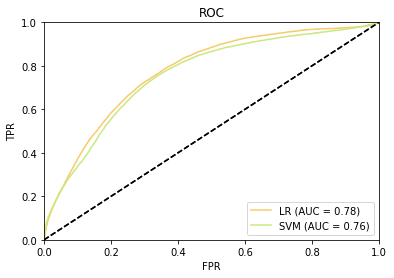

In [6]:
plt.clf()

def plotROC(truth, prediction, label):
    fpr, tpr, thresholds = roc_curve(truth, prediction)
    roc_auc = auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color=c, label= label+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    return (fpr, tpr, thresholds)

lr_fpr, lr_tpr, lr_thresholds = plotROC(data_test["Y"], lr.predict_proba(data_test.drop("Y",1))[:,1], 'LR')
lr_roc_param_df = pd.DataFrame(data={'lr_fpr': lr_fpr, 'lr_tpr': lr_tpr, 'lr_threshold': lr_thresholds})
svm_fpr, svm_tpr, svm_thresholds = plotROC(data_test["Y"], svm.decision_function(data_test.drop("Y",1)), 'SVM')        
svm_roc_param_df = pd.DataFrame(data={'svm_fpr': svm_fpr, 'svm_tpr': svm_tpr, 'svm_threshold': svm_thresholds})
roc_param_df = pd.concat([lr_roc_param_df, svm_roc_param_df], axis=1)
plt.show()

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

In [7]:
roc_param_df["lr_threshold"][roc_param_df["lr_tpr"] < roc_param_df["svm_tpr"]]

1       0.996941
2       0.994668
3       0.994252
4       0.994041
5       0.993816
6       0.991259
7       0.990357
8       0.987365
9       0.987157
10      0.985278
11      0.983298
12      0.981902
13      0.981852
14      0.977474
15      0.977116
16      0.975039
17      0.974574
18      0.974111
19      0.973898
20      0.973478
21      0.973446
22      0.971732
23      0.971558
24      0.970729
25      0.970440
26      0.968895
27      0.967958
28      0.966292
29      0.966287
30      0.962717
          ...   
1603    0.612491
1605    0.612398
1607    0.612177
1609    0.612050
1613    0.611790
1615    0.611716
1617    0.611579
1618    0.611528
1619    0.611473
1621    0.611398
1622    0.611347
1623    0.611341
1624    0.611297
1625    0.611249
1626    0.611200
1627    0.611187
1628    0.611143
1629    0.611130
1630    0.611124
1631    0.611121
1632    0.611003
1633    0.610996
1634    0.610909
1635    0.610891
1636    0.610750
1637    0.610691
1639    0.610227
1649    0.6092

1. From the above ROC curve and AUC it is evident that the Logistic Regression Model (AUC=0.78) will generally perform better at ranking the test set than SVM (AUC=0.76)
2. For the above classification thresholds Logistic Regression Model underperforms the SVM in classification metric (such as TPR)   

### Part 3: Model selection with cross-validation (10 points)
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 1000 instances, we will have to use cross-validation to find the optimal $C$.

1\. Write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Performs two loops
  - Outer Loop: `for each f in range(k)`:
    - Splits the data into `data_train` & `data_validate` according to cross-validation logic
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc-c1,auc-c2,..auc-ck]`

In [8]:
#Imports
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

In [9]:
def xValSVM(dataset, label_name, k, cs):
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=0)
    splits_df = pd.DataFrame(columns=['Train','Test'])
    for train, test in skf.split(dataset.drop(label_name,1), dataset[label_name]):
        splits_df = splits_df.append({'Train': train, 'Test':test}, ignore_index=True) 
    aucs = {c:[] for c in cs}
    for f in range(k):
        data_validate = dataset.iloc[splits_df['Test'].iloc[f-1]]
        data_train = dataset.iloc[splits_df['Train'].iloc[f-1]]
        for c in cs:
            svm = SVC(C=c, kernel='linear')
            svm.fit(data_train.drop(label_name,1), 2*data_train[label_name]-1)
            fpr, tpr, thresholds = roc_curve(data_validate[label_name], svm.decision_function(data_validate.drop(label_name,1)))
            roc_auc = auc(fpr, tpr) 
            aucs[c].append(roc_auc)     
    return aucs

2\. Using the function written above, do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1).
2.	Call aucs = xValSVM(train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) 
4.	Compute the value for max(meanAUC-StdErr(AUC)) across all values of c.
5.	Generate a plot with the following:
a.	Log10(c) on the x-axis
b.	1 series with mean(AUC) for each c
c.	1 series with mean(AUC)-stderr(AUC) for each c (use ‘k+’ as color pattern)
d.	1 series with mean(AUC)+stderr(AUC) for each c (use ‘k--‘ as color pattern)
e.	a reference line for max(AUC-StdErr(AUC)) (use ‘r’ as color pattern)

Then answer the question: Did the model parameters selected beat the out-of-the-box model for SVM? 

In [10]:
cs = np.linspace(10**-8, 10**1, num=10)
aucs = xValSVM(data_train,'Y',10,cs)
auc_stat = pd.DataFrame(columns=['C','Mean','StdErr','Mean-StdErr','Mean+StdErr'])
auc_stat['C'] = cs
auc_stat['Mean'] = [np.mean(aucs[c]) for c in cs]
auc_stat['StdErr'] = [np.std(aucs[c]) for c in cs]
auc_stat['Mean-StdErr'] = auc_stat['Mean'] - auc_stat['StdErr']
auc_stat['Mean+StdErr'] = auc_stat['Mean'] + auc_stat['StdErr']

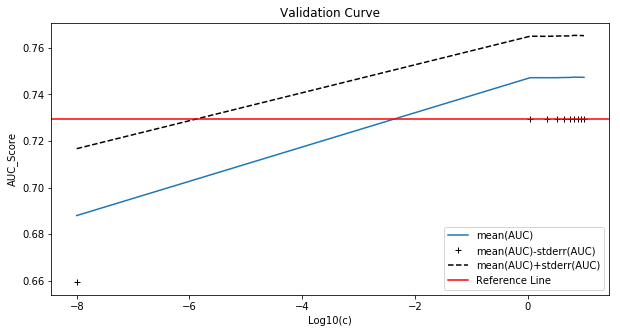

In [11]:
plt.figure(figsize=(10,5))
plt.plot(np.log10(cs), auc_stat['Mean'], label= 'mean(AUC)')
plt.plot(np.log10(cs), auc_stat['Mean-StdErr'], 'k+',label= 'mean(AUC)-stderr(AUC)')
plt.plot(np.log10(cs), auc_stat['Mean+StdErr'],'k--',label= 'mean(AUC)+stderr(AUC)')
plt.axhline(y=max(auc_stat['Mean-StdErr']),color = 'r', label= 'Reference Line')
plt.xlabel('Log10(c)')
plt.ylabel('AUC_Score')
plt.title('Validation Curve')
plt.legend(loc="lower right")
plt.show()

In [12]:
print(auc_stat[['C', 'Mean+StdErr']][auc_stat['Mean+StdErr'] > 0.76])

           C  Mean+StdErr
1   1.111111     0.764974
2   2.222222     0.764917
3   3.333333     0.765050
4   4.444444     0.765103
5   5.555556     0.765095
6   6.666667     0.765342
7   7.777778     0.765280
8   8.888889     0.765269
9  10.000000     0.765208


All the model parameter values i.e. "C" selected above will beat the out-of-the-box model for SVM as the AOC value is greater than 0.76
Through this cross validation process, we can select the value of C = 10 as it gives the highest AOC value of 0.765208

# Part 4: Learning Curve with Bootstrapping
In this HW we are trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, we test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  We can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.




1\. Create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). For SVM, use the value of C identified using the 1 standard error method from part 3.    
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list

-	Returns the mean(AUC) and Standard Error(mean(AUC)) across all bootstrap samples


In [13]:
def modBootstrapper(train, test, nruns, sampsize, lr, c):
    aucs = []
    aucs_score = []
    for iter_num in range(nruns):
        train_sample = train.sample(n=sampsize, replace=True)
        if lr==1:
            lr_model = linear_model.LogisticRegression(C=1e30)
            lr_model.fit(train_sample.drop("Y",1), train_sample["Y"])
            fpr, tpr, thresholds = roc_curve(test["Y"], lr_model.predict_proba(test.drop("Y",1))[:,1])
            roc_auc = auc(fpr, tpr)
            aucs_score.append(roc_auc)
        elif lr==0:
            svm = SVC(kernel='linear', C=c)
            svm.fit(train_sample.drop("Y",1), 2*train_sample["Y"]-1)
            fpr, tpr, thresholds = roc_curve(test["Y"], svm.decision_function(test.drop("Y",1)))
            roc_auc = auc(fpr, tpr)
            aucs_score.append(roc_auc)
    aucs.append(np.mean(aucs_score))
    aucs.append(np.std(aucs_score))
    return aucs

2\. For both LR and SVM, run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. (Note, this might take 10-15 mins … feel free to go grab a drink or watch Youtube while this runs).

Generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-stderr(AUC) for each c (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+stderr(AUC) for each c (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)


In [14]:
samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]
aucs_lr_df = pd.DataFrame(columns=['AUC_Mean','AUC_STD'])
for sampsize in samplesizes: 
    aucs_lr = modBootstrapper(data_train, data_test, 20, sampsize, 1, None)
    aucs_lr_df = aucs_lr_df.append({'AUC_Mean': aucs_lr[0], 'AUC_STD':aucs_lr[1]}, ignore_index=True)    

In [15]:
samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]
aucs_svm_df = pd.DataFrame(columns=['AUC_Mean','AUC_STD'])
for sampsize in samplesizes: 
    aucs_svm = modBootstrapper(data_train, data_test, 20, sampsize, 0, 10)
    aucs_svm_df = aucs_svm_df.append({'AUC_Mean': aucs_svm[0], 'AUC_STD':aucs_svm[1]}, ignore_index=True)    

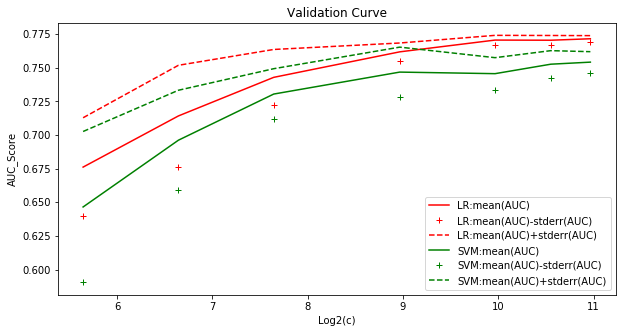

In [16]:
plt.figure(figsize=(10,5))
plt.plot(np.log2(samplesizes), aucs_lr_df['AUC_Mean'],'r', label= 'LR:mean(AUC)')
plt.plot(np.log2(samplesizes), aucs_lr_df['AUC_Mean']-aucs_lr_df['AUC_STD'],'r+',label= 'LR:mean(AUC)-stderr(AUC)')
plt.plot(np.log2(samplesizes), aucs_lr_df['AUC_Mean']+aucs_lr_df['AUC_STD'],'r--',label= 'LR:mean(AUC)+stderr(AUC)')
plt.plot(np.log2(samplesizes), aucs_svm_df['AUC_Mean'],'g',label= 'SVM:mean(AUC)')
plt.plot(np.log2(samplesizes), aucs_svm_df['AUC_Mean']-aucs_svm_df['AUC_STD'],'g+', label= 'SVM:mean(AUC)-stderr(AUC)')
plt.plot(np.log2(samplesizes), aucs_svm_df['AUC_Mean']+aucs_svm_df['AUC_STD'],'g--',label= 'SVM:mean(AUC)+stderr(AUC)')
plt.xlabel('Log2(c)')
plt.ylabel('AUC_Score')
plt.title('Validation Curve')
plt.legend(loc="lower right")
plt.show()

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?


From the above plot it is evident that SVM is more suitable for smaller sample sizes as it has a higher AOC_score band as compared to Logistic Regression.
It is not worth making investment in doubling the data if it costs twice since it will just improve the AUC score by a small amount for large sample sizes by using Logistic Regression 

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased?



The standard techniques like K-fold cross validation will not be biased if the data is Independent and Identically Distributed and the data also contains balanced classes.If the data contains unbalanced classes it is good to use StratifiedKFold technique as used above since StratifiedKFold will create folds preserving the proportion of class labels in every fold.
If the samples have been generated using a time-dependent process, it’s safer to use a time-series aware cross-validation scheme like Time Series Split technique.
Similarly if we know that the generative process has a group structure (samples collected from different subjects, experiments, measurement devices) it safer to use group-wise cross-validation like Group k-fold.
So it is important to use different cross validation techniques depending on the dataset in order to prevent/reduce bias  